In [73]:
import numpy as np
import matplotlib.pyplot as plt

In [74]:
# Mandelbrot set function
def mandelbrot(c, max_iter):
    z = 0
    for n in range(max_iter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return max_iter

In [96]:
# Define the weighting functions

# Higher weight near the boundary
def weighting_function(x, y, a, xmin, xmax, ymin, ymax):
    distance_to_boundary = np.sqrt(x**2 + y**2)
    return np.exp(-0.1 * distance_to_boundary)

# Quadratic weighting function
def gaussian_weighting(x, y, a, xmin, xmax, ymin, ymax):
    # Calculate the maximum distance from the origin in the rectangular region
    max_distance = np.sqrt(max((xmax - xmin)**2, (ymax - ymin)**2))
    # Quadratic weighting function
    return np.exp(-a * (x**2 + y**2) / max_distance**2)

# Radial Basis Function (RBF) Weighting Function
def rbf_weighting(x, y, a, xmin, xmax, ymin, ymax):
    # Calculate the maximum distance from the origin in the rectangular region
    max_distance = np.sqrt(max((xmax - xmin)**2, (ymax - ymin)**2))
    # RBF weighting function
    return np.exp(-a * np.sqrt((x - (xmin + xmax) / 2)**2 + (y - (ymin + ymax) / 2)**2) / max_distance)

In [97]:
# Monte Carlo integration with importance sampling
def monte_carlo_importance_sampling(iterations, samples, xmin, xmax, ymin, ymax, total_area, weighting_func, *args):
    total_samples = iterations * samples
    area_estimations = np.zeros(iterations)

    for i in range(iterations):
        area_estimate = 0
        for _ in range(samples):
            # Sample points with importance weights
            x = np.random.uniform(xmin, xmax)
            y = np.random.uniform(ymin, ymax)
            # weight = weighting_func(x, y, *args)
            weight = weighting_func(x, y, *args, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)


            # Check if the point is in the Mandelbrot set
            if mandelbrot(complex(x, y), 100) == 100:
                area_estimate += weight

        # Normalize the result and scale by the total area
        area_estimate /= samples
        scaled_estimate = area_estimate * total_area

        area_estimations[i] = scaled_estimate

    # Calculate absolute errors
    absolute_errors = np.abs(area_estimations[1:] - area_estimations[:-1])

    return area_estimations, absolute_errors

In [105]:
def run_monte_carlo_simulation(i_values, s_values, xmin, xmax, ymin, ymax, total_area, num_simulations, weighting_function, a_value):
    average_estimates = []
    average_errors = []

    for s in s_values:
        row_estimate = []
        row_error = []

        for i in i_values:
            simulation_results = [monte_carlo_importance_sampling(i, s, xmin, xmax, ymin, ymax, total_area, weighting_function, a_value) for _ in range(num_simulations)]
            average_estimate = np.mean([np.mean(results[0]) for results in simulation_results])
            average_error = np.mean([np.mean(np.abs(results[0][1:] - results[0][:-1])) for results in simulation_results])

            row_estimate.append(average_estimate)
            row_error.append(average_error)

        average_estimates.append(row_estimate)
        average_errors.append(row_error)

    return average_estimates, average_errors

In [106]:
# Parameters
i_values = range(1, 101, 5)
s_values = [200, 400, 600, 800, 1000]  # Adjust sample sizes as needed
xmin, xmax, ymin, ymax = -2.0, 1.0, -1.5, 1.5
total_area = (xmax - xmin) * (ymax - ymin)
num_simulations = 2

# Calculate the maximum distance from the origin in the rectangular region; used in quadratic weighting
max_distance = np.sqrt(max((xmax - xmin)**2, (ymax - ymin)**2))

# Adjust the a value based on the desired spread of influence; used in quadratic weighting
a_value = 1.0 / (2 * max_distance)

# Original weighting function; higher weight near the edge
average_estimates_original, average_errors_original = run_monte_carlo_simulation(
    i_values, s_values, xmin, xmax, ymin, ymax, total_area, num_simulations, weighting_function, a_value
)

# Gaussian weighting function with adjusted a value
average_estimates_quadratic, average_errors_quadratic = run_monte_carlo_simulation(
    i_values, s_values, xmin, xmax, ymin, ymax, total_area, num_simulations, gaussian_weighting, a_value
)

# RBF weighting function
average_estimates_rbf, average_errors_rbf = run_monte_carlo_simulation(
    i_values, s_values, xmin, xmax, ymin, ymax, total_area, num_simulations, rbf_weighting, a_value
)

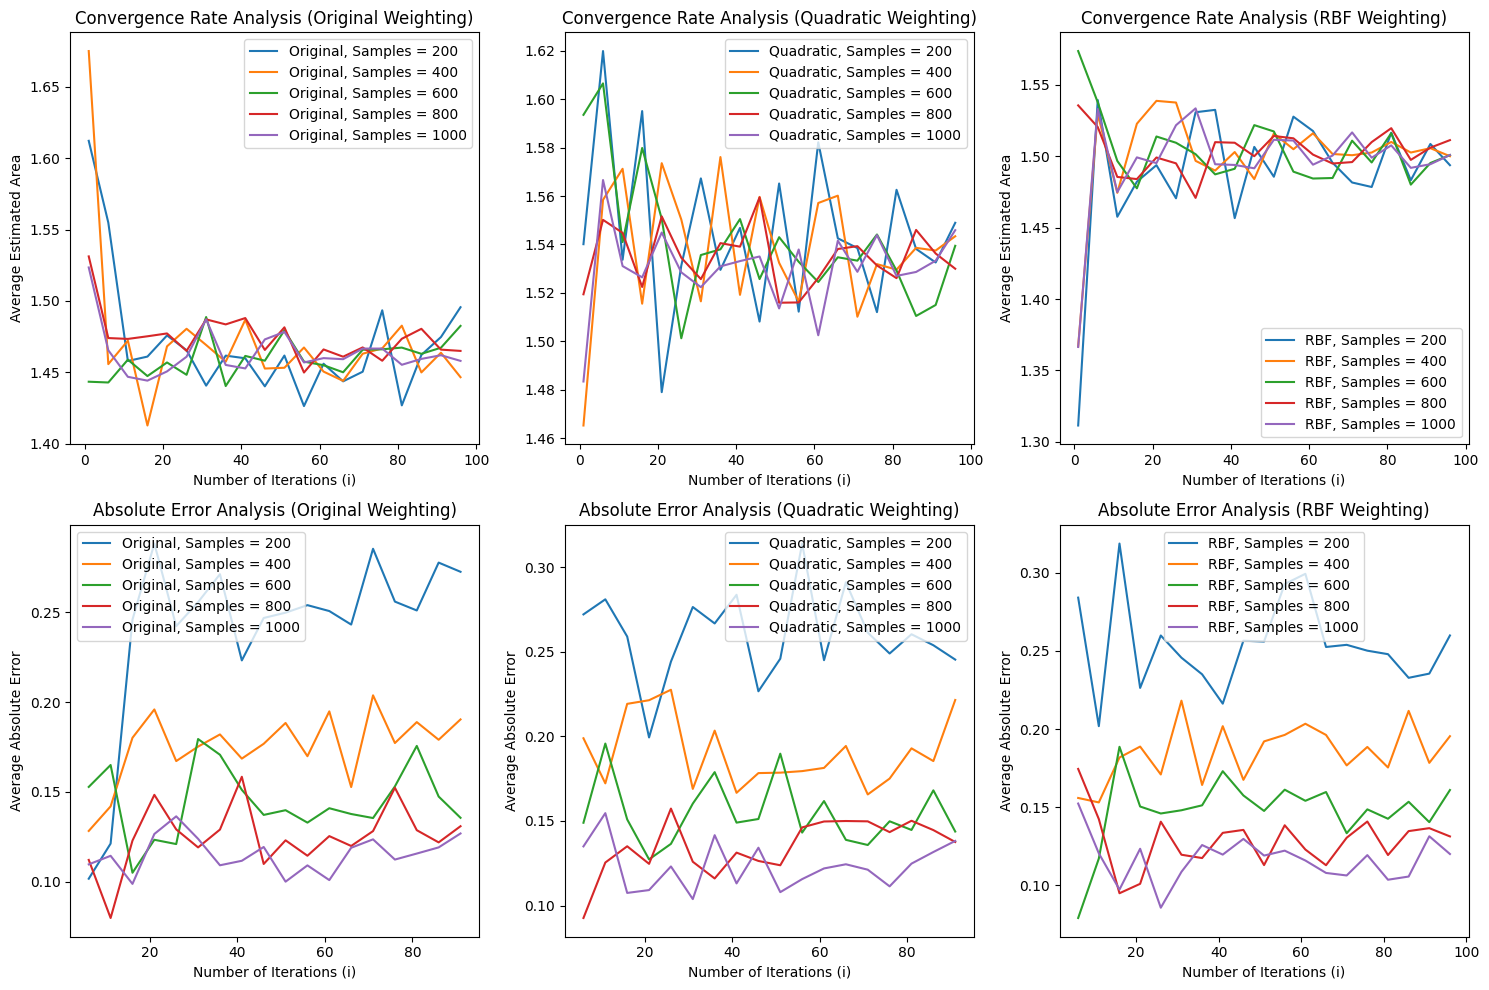

In [117]:
import matplotlib.pyplot as plt

# Plot the results for the weighting functions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot for average estimated area
for idx, s in enumerate(s_values):
    axes[0, 0].plot(i_values, average_estimates_original[idx], label=f'Original, Samples = {s}')
    axes[0, 1].plot(i_values, average_estimates_quadratic[idx], label=f'Quadratic, Samples = {s}')
    axes[0, 2].plot(i_values, average_estimates_rbf[idx], label=f'RBF, Samples = {s}')

axes[0, 0].set_title('Convergence Rate Analysis (Original Weighting)')
axes[0, 0].set_ylabel('Average Estimated Area')
axes[0, 0].legend()

axes[0, 1].set_title('Convergence Rate Analysis (Quadratic Weighting)')
axes[0, 1].legend()

axes[0, 2].set_title('Convergence Rate Analysis (RBF Weighting)')
axes[0, 2].set_ylabel('Average Estimated Area')
axes[0, 2].legend()

# Plot for average absolute error
for idx, s in enumerate(s_values):
    min_length = min(len(i_values[:-1]), len(average_errors_original[idx]))
    axes[1, 0].plot(i_values[:min_length], average_errors_original[idx][:min_length], label=f'Original, Samples = {s}')
    axes[1, 1].plot(i_values[:min_length], average_errors_quadratic[idx][:min_length], label=f'Quadratic, Samples = {s}')

    # Ensure average_errors_rbf has the same length as i_values
    min_length_rbf = min(len(i_values), len(average_errors_rbf[idx]))
    axes[1, 2].plot(i_values[:min_length_rbf], average_errors_rbf[idx][:min_length_rbf], label=f'RBF, Samples = {s}')

# Set x-label on both the top and bottom rows
axes[0, 0].set_xlabel('Number of Iterations (i)')
axes[0, 1].set_xlabel('Number of Iterations (i)')
axes[0, 2].set_xlabel('Number of Iterations (i)')

axes[1, 0].set_xlabel('Number of Iterations (i)')
axes[1, 1].set_xlabel('Number of Iterations (i)')
axes[1, 2].set_xlabel('Number of Iterations (i)')

axes[1, 0].set_ylabel('Average Absolute Error')
axes[1, 0].set_title('Absolute Error Analysis (Original Weighting)')
axes[1, 0].legend()

# Additional adjustments for the third column
axes[1, 1].set_ylabel('Average Absolute Error')
axes[1, 1].set_title('Absolute Error Analysis (Quadratic Weighting)')
axes[1, 1].legend()

axes[1, 2].set_ylabel('Average Absolute Error')
axes[1, 2].set_title('Absolute Error Analysis (RBF Weighting)')
axes[1, 2].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
